In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
torch.manual_seed(42)

In [4]:
train_path = "training.csv"
test_path = "test.csv"

In [5]:
features_columns = [
            'left_eye_center_x', 'left_eye_center_y',
            'right_eye_center_x','right_eye_center_y',
            'left_eye_inner_corner_x','left_eye_inner_corner_y',
            'left_eye_outer_corner_x','left_eye_outer_corner_y',
            'right_eye_inner_corner_x','right_eye_inner_corner_y',
            'right_eye_outer_corner_x','right_eye_outer_corner_y',
            'left_eyebrow_inner_end_x','left_eyebrow_inner_end_y',
            'left_eyebrow_outer_end_x','left_eyebrow_outer_end_y',
            'right_eyebrow_inner_end_x','right_eyebrow_inner_end_y',
            'right_eyebrow_outer_end_x','right_eyebrow_outer_end_y',
            'nose_tip_x','nose_tip_y',
            'mouth_left_corner_x','mouth_left_corner_y',
            'mouth_right_corner_x','mouth_right_corner_y',
            'mouth_center_top_lip_x','mouth_center_top_lip_y',
            'mouth_center_bottom_lip_x','mouth_center_bottom_lip_y'
            ]

In [6]:
import pandas as pd
import numpy as np
import torch

# Function to convert each row into a NumPy array
def row_to_np(row):
    return np.array(row.split()).reshape(96, 96).astype(float)

class FacialKeypointsDataset(torch.utils.data.Dataset):
    """Some Information about FacialKeypointsDataset"""
    def __init__(self, data_path, transform=None, train=True):
        df = pd.read_csv(data_path)
        self.train = train
        self.features_columns = features_columns
        self.transform = transform

        if train:
            self.features = df[self.features_columns].ffill()
        self.images = df['Image'].apply(row_to_np)

    def __getitem__(self, index):

        if self.train:
            features = torch.tensor(self.features.iloc[index].to_numpy()).type(torch.float32)
            image = torch.tensor(self.images.iloc[index]).unsqueeze(dim=0).type(torch.float32)

            if self.transform is not None:
                image = self.transform(image)

            return image, features
        else:
            return torch.tensor(self.images.iloc[index]).unsqueeze(dim=0).type(torch.float32)

    def __len__(self):
        return len(self.images)

In [7]:
def mean_std(loader):
  mean, std = 0, 0
  for images, _ in loader:
    # shape of images = [b,c,w,h]
    mean += images.mean([0,2,3])
    std += images.std([0,2,3])
  mean = mean/(len(loader)*BATCH_SIZE)
  std = std/(len(loader)*BATCH_SIZE)
  print(f'mean: {mean}, std: {std}')
  return mean, std

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_dataset = FacialKeypointsDataset(data_path=train_path, train=True)

In [9]:
mean, std = mean_std(DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False))

mean: tensor([0.9783]), std: tensor([0.4610])


In [10]:
train_dataset = FacialKeypointsDataset(data_path=train_path, transform=transforms.Normalize(mean=mean, std=std), train=True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

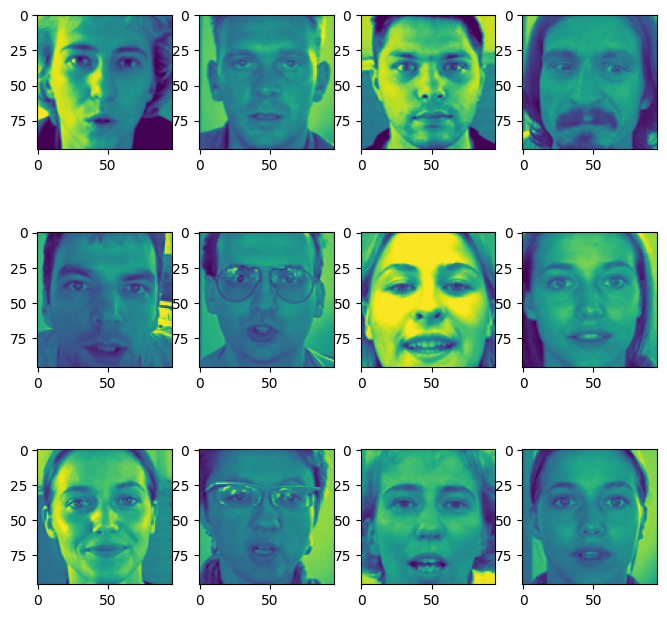

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img, _ = train_dataset[i]
    img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
# Can be used to calculate output sizes after each layer
# def calc_size(input_size, kernel_size, padding, stride):
#     return (input_size + 2* padding - kernel_size + 1) / stride

In [30]:
# Model without dropouts and batchNormalization

# Images have (96, 96, 1) shape, thats wht CH = 1
INPUT_CHANNELS = 1 
FILTERS_NUMBER = 10
CONV_KERNEL_SIZE = 3
MAX_POOL_KERNEL_SIZE = 3

class CnnModel(nn.Module):
    """Some Information about CnnModel"""
    def __init__(self):
        super(CnnModel, self).__init__()
        self.first_layer = nn.Sequential(
            nn.Conv2d(in_channels=INPUT_CHANNELS, out_channels=FILTERS_NUMBER, kernel_size=CONV_KERNEL_SIZE),
            nn.BatchNorm2d(num_features=FILTERS_NUMBER),
            nn.ReLU(),
            nn.Conv2d(in_channels=FILTERS_NUMBER, out_channels=FILTERS_NUMBER, kernel_size=CONV_KERNEL_SIZE),
            nn.BatchNorm2d(num_features=FILTERS_NUMBER),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=MAX_POOL_KERNEL_SIZE)
        )

        self.second_layer = nn.Sequential(
            nn.Conv2d(in_channels=FILTERS_NUMBER, out_channels=FILTERS_NUMBER, kernel_size=CONV_KERNEL_SIZE),
            nn.BatchNorm2d(num_features=FILTERS_NUMBER),
            nn.ReLU(),
            nn.Conv2d(in_channels=FILTERS_NUMBER, out_channels=FILTERS_NUMBER, kernel_size=CONV_KERNEL_SIZE),
            nn.BatchNorm2d(num_features=FILTERS_NUMBER),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=MAX_POOL_KERNEL_SIZE)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=FILTERS_NUMBER * 8 * 8, out_features=len(features_columns))
        )

    def forward(self, x):
        x = self.first_layer(x)
        # print(x.shape)
        x = self.second_layer(x)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x

In [31]:
from tqdm.auto import tqdm
import torchmetrics

EPOCHS = 20
LEARNING_RATE = 1e-2

model = CnnModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss().to(device)

# loop over the dataset multiple times
for epoch in tqdm(range(EPOCHS)):
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass
        outputs = model(inputs)

        # # calculate loss
        loss = criterion(outputs, labels)
        running_loss += loss

        # zero the parameter gradients
        optimizer.zero_grad()

        # loss backward
        loss.backward()

        # optimizer step
        optimizer.step()

        

    print('Loss: {}'.format(running_loss))

print('Finished Training')

  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

Loss: 10348.69140625


 10%|█         | 2/20 [00:01<00:16,  1.06it/s]

Loss: 598.9545288085938


 15%|█▌        | 3/20 [00:02<00:15,  1.12it/s]

Loss: 543.953369140625


 20%|██        | 4/20 [00:03<00:13,  1.15it/s]

Loss: 548.2723999023438


 25%|██▌       | 5/20 [00:04<00:12,  1.17it/s]

Loss: 497.602294921875


 30%|███       | 6/20 [00:05<00:11,  1.17it/s]

Loss: 450.5591735839844


 35%|███▌      | 7/20 [00:06<00:11,  1.18it/s]

Loss: 431.1438293457031


 40%|████      | 8/20 [00:06<00:10,  1.19it/s]

Loss: 420.53839111328125


 45%|████▌     | 9/20 [00:07<00:09,  1.19it/s]

Loss: 397.9847717285156


 50%|█████     | 10/20 [00:08<00:08,  1.19it/s]

Loss: 395.02099609375


 55%|█████▌    | 11/20 [00:09<00:07,  1.19it/s]

Loss: 387.141845703125


 60%|██████    | 12/20 [00:10<00:06,  1.19it/s]

Loss: 366.8839416503906


 65%|██████▌   | 13/20 [00:11<00:05,  1.19it/s]

Loss: 362.97674560546875


 70%|███████   | 14/20 [00:11<00:05,  1.19it/s]

Loss: 379.058837890625


 75%|███████▌  | 15/20 [00:12<00:04,  1.19it/s]

Loss: 375.0494689941406


 80%|████████  | 16/20 [00:13<00:03,  1.20it/s]

Loss: 349.8131103515625


 85%|████████▌ | 17/20 [00:14<00:02,  1.17it/s]

Loss: 353.6742858886719


 90%|█████████ | 18/20 [00:15<00:01,  1.18it/s]

Loss: 359.0647277832031


 95%|█████████▌| 19/20 [00:16<00:00,  1.18it/s]

Loss: 347.1964416503906


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]

Loss: 346.2884216308594
Finished Training
